In [1]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from metloom.pointdata import SnotelPointData
from dataretrieval import nwis

import datetime as dt

import rioxarray as rioxr
import geopandas as gpd
import fiona 
fiona.drvsupport.supported_drivers['KML'] = 'rw'
import contextily as cx

import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import plot, mask

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/metloom/pointdata/base.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [102]:
# Polygon for the East and Taylor Rivers
east_taylor_polygon = gpd.read_file('../multisite/polygons/east_taylor.json')

### Pull in the SNOTEL data and Locations, then plot them on a map

In [3]:
er_sntl_data = xr.open_dataset('/storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

In [4]:
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("680:CO:SNTL", "Park Cone")
park_cone_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("737:CO:SNTL", "Schofield Pass")
schofield_pass_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("1141:CO:SNTL", "Upper Taylor")
upper_taylor_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]


In [5]:
# Get locations of sites
site_info = nwis.get_info(sites=['09112500','09107000 '])

In [6]:
site_info_pts = gpd.GeoDataFrame(site_info[0], geometry=gpd.points_from_xy(site_info[0]['dec_long_va'],site_info[0]['dec_lat_va']))
site_info_pts = site_info_pts.set_crs('4326')
gage_pts_local = site_info_pts.to_crs(east_taylor_polygon.crs)

### Start building basemap

In [7]:
sntl_gdf = gpd.GeoSeries([butte_loc,park_cone_loc,schofield_pass_loc,upper_taylor_loc]).set_crs('4326')
sntl_gdf_local = sntl_gdf.to_crs(east_taylor_polygon.crs)

In [ ]:
#Now making a basemap in contextily
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
fig, ax = plt.subplots(figsize=(12,12))
east_taylor_polygon[east_taylor_polygon['name']=='Taylor River'].geometry.plot(color=CB_color_cycle[0], linewidth=3,edgecolor='k',alpha=0.5, ax=ax)
east_taylor_polygon[east_taylor_polygon['name']=='East River'].geometry.plot(color=CB_color_cycle[3], linewidth=3,edgecolor='k', alpha=0.5, ax=ax)

#Add north arrow, https://stackoverflow.com/a/58110049/604456
x1, y1, arrow_length = 0.9, 0.85, 0.07
ax.annotate('N', xy=(x1, y1), xytext=(x1, y1-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
# Add scale-bar
x, y, scale_len = 379000, 4.3125e6, 5000 #arrowstyle='-'
scale_rect = patches.Rectangle((x,y),scale_len,200,linewidth=1,edgecolor='k',facecolor='k')
ax.add_patch(scale_rect)
ax.text(x+scale_len/2, y-1600, s='5 KM', fontsize=15, horizontalalignment='center')

# Add text for East River
ax.text(east_taylor_polygon[east_taylor_polygon['name']=='East River'].centroid.x.values[0], 
        east_taylor_polygon[east_taylor_polygon['name']=='East River'].centroid.y.values[0], 
        'East River',
        fontsize=20, 
        fontweight='bold',
        horizontalalignment='center')

# Add text for Taylor River
ax.text(east_taylor_polygon[east_taylor_polygon['name']=='Taylor River'].centroid.x.values[0], 
        east_taylor_polygon[east_taylor_polygon['name']=='Taylor River'].centroid.y.values[0], 
        'Taylor River',
        fontsize=20,
        fontweight='bold', 
        horizontalalignment='center')


#Add in SNOTELs as points
sntl_gdf_local.plot(c=CB_color_cycle[2], alpha=1, ec='k', label='SNOTEL Site', ax=ax, markersize=200)
#Add in SNOTELs as points
gage_pts_local.plot(c=CB_color_cycle[4], alpha=1, ec='k', label='USGS Streamgage', ax=ax, markersize=200)

#Now making a nice legend
ax.legend(loc='upper right', prop={'size': 16})

#Now adding in the basemap imagery
cx.add_basemap(ax, crs=east_taylor_polygon.crs.to_string(), source=cx.providers.OpenTopoMap)
fig.savefig('./figures/east_taylor_overview.png')

### Figure of Climatological Means for ET and Precip for East and Taylor Rivers

In [122]:
wrf_climatology_er_ds = xr.open_dataset(
    '/storage/dlhogan/sos/data/wrf_climatology_precip.nc', decode_coords="all"
)
wrf_climatology_er_ds = wrf_climatology_er_ds.rename_dims({'south_north':'y',
                                                           'west_east':'x'})
wrf_climatology_er_ds = wrf_climatology_er_ds.assign_coords({
        'y': wrf_climatology_er_ds[f'XLAT'].values[:,0],
        'x': wrf_climatology_er_ds[f'XLONG'].values[0,:]})

wrf_climatology_tr_ds = xr.open_dataset(
    '/storage/dlhogan/sos/data/wrf_climatology_precip_taylor.nc',decode_coords="all"
)
wrf_climatology_tr_ds = wrf_climatology_tr_ds.rename_dims({'south_north':'y',
                                                           'west_east':'x'})
wrf_climatology_tr_ds = wrf_climatology_tr_ds.assign_coords({
        'y': wrf_climatology_tr_ds[f'XLAT'].values[:,0],
        'x': wrf_climatology_tr_ds[f'XLONG'].values[0,:]})

In [141]:
def reproject_ds(ds, polygon):
    ds = ds.rio.write_crs('4326')
    return ds

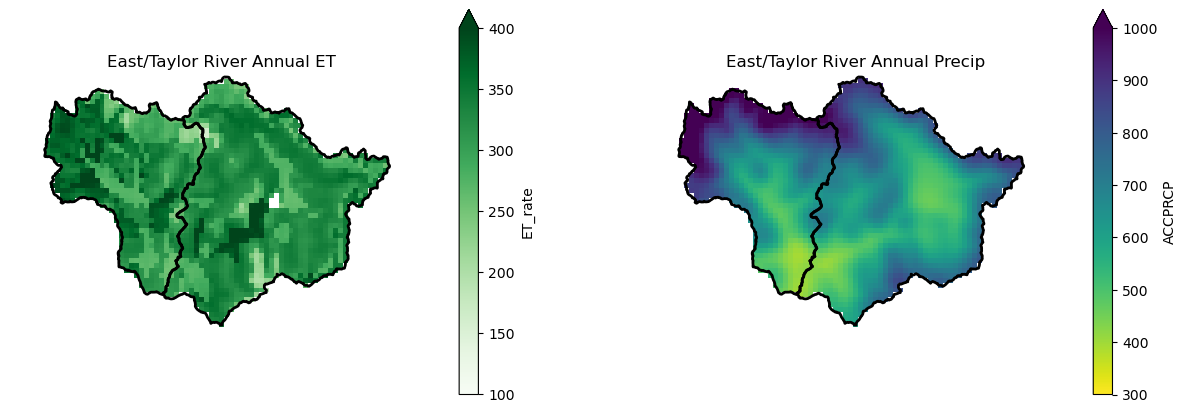

In [189]:
# Create plot for annual ET and Precip sums over the year
fig, axs = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
axs=axs.ravel()
labels = ['East/Taylor River Annual ET', 'East/Taylor River Annual Precip']
mask = ['EAST_MASK', 'TAYLOR_MASK']
river = ['East Basin', 'Taylor Basin']
east_taylor_polygon_4326 = east_taylor_polygon.to_crs(epsg='4326')

for i,ds in enumerate([wrf_climatology_er_ds, wrf_climatology_tr_ds]):
    # Get ET and Plot
    tmp_et = ds['ET_rate'].where(ds[mask[i]]==True).resample(XTIME='1Y').sum(dim='XTIME').mean(dim='XTIME')
    # Filter out reservoir
    tmp_et = tmp_et.where((tmp_et<1000)&(tmp_et>0))
    et_plt = tmp_et.plot(ax=axs[0], cmap='Greens', vmin=100, vmax=400)

    # Get Precip, reporject and plot
    tmp_p = ds['ACCPRCP'].where((ds[mask[i]]==True) & (ds.XTIME.dt.month==9)).mean(dim='XTIME')
    p_plt = tmp_p.plot.imshow(ax=axs[1], cmap='viridis_r', vmin=300, vmax=1000)

    # Plot East and Taylor River Boundaries
    east_taylor_polygon_4326.boundary.plot( ax=axs[i], color='k', lw=2)
    for ax in axs:
        ax.set_ylim(38.6,39.06)
        # cx.add_basemap(ax, crs=east_taylor_polygon_4326.crs.to_string(), source=cx.providers.OpenTopoMap)
        ax.axis('off')
    # Remove extra colorbar
    cbar1 = et_plt.colorbar
    cbar2 = p_plt.colorbar
    if i == 0:
        cbar1.remove()
        cbar2.remove()
    axs[0].set_title(labels[0])
    axs[1].set_title(labels[1])

In [69]:
er_annual_mean = wrf_climatology_er_ds.where(wrf_climatology_er_ds[mask[0]]==True).groupby('WY').sum(dim='XTIME').sum(dim=['south_north','west_east'])/757
tr_annual_mean = wrf_climatology_tr_ds.where(wrf_climatology_tr_ds[mask[1]]==True).groupby('WY').sum(dim='XTIME').sum(dim=['south_north','west_east'])/1229

In [169]:
p.replace

<xarray.DataArray 'ET_rate' (y: 74, x: 85)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    XLAT     (y, x) float32 38.49 38.49 38.49 38.49 ... 39.15 39.15 39.15 39.15
    XLONG    (y, x) float32 -107.2 -107.2 -107.2 -107.2 ... -106.2 -106.2 -106.2
  * y        (y) float32 38.49 38.5 38.51 38.52 ... 39.12 39.13 39.14 39.15
  * x        (x) float32 -107.2 -107.2 -107.2 -107.2 ... -106.2 -106.2 -106.2

In [78]:
ds = wrf_climatology_er_ds.where(wrf_climatology_er_ds[mask[0]]==True).groupby('WY').sum(dim='XTIME')

In [ ]:

aso_east_taylor_dem = rioxr.open_rasterio('/storage/dlhogan/sos/data/ASO/ASO_3M_PCDTM.001/2018.09.08/ASO_3M_PCDTM_USCOGE_20180908_20180913.tif').squeeze()
aso_east_dem = aso_east_taylor_dem.rio.clip(upper_east_river_poly.geometry)

In [74]:
er_annual_mean_p = wrf_climatology_er_ds['ACCPRCP'].where((wrf_climatology_er_ds[mask[0]]==True) & (wrf_climatology_er_ds.XTIME.dt.month==9)).groupby('WY').mean().sum(dim=['south_north','west_east'])/757
tr_annual_mean_p = wrf_climatology_tr_ds['ACCPRCP'].where((wrf_climatology_tr_ds[mask[1]]==True) & (wrf_climatology_tr_ds.XTIME.dt.month==9)).groupby('WY').mean().sum(dim=['south_north','west_east'])/1229



In [55]:
#Now making a basemap in contextily
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

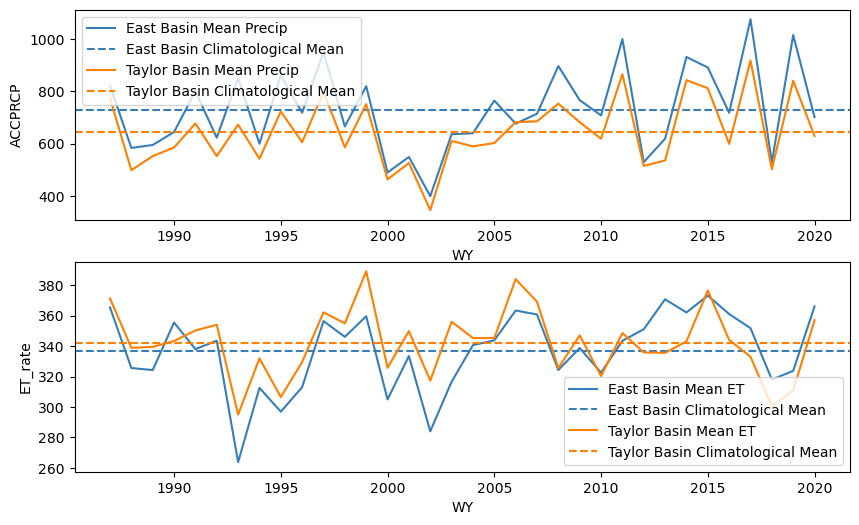

In [186]:
fig, axs = plt.subplots(2, figsize=(10,6))
er_annual_mean_p.plot(ax=axs[0], label='East Basin Mean Precip', color=CB_color_cycle[0])
axs[0].axhline(er_annual_mean_p.mean(), ls='--', color=CB_color_cycle[0],label = 'East Basin Climatological Mean')
tr_annual_mean_p.plot(ax=axs[0], label='Taylor Basin Mean Precip', color=CB_color_cycle[1])
axs[0].axhline(tr_annual_mean_p.mean(), ls='--', color=CB_color_cycle[1], label = 'Taylor Basin Climatological Mean')
axs[0].legend()

er_annual_mean['ET_rate'].plot(ax=axs[1], label='East Basin Mean ET', color=CB_color_cycle[0])
axs[1].axhline(er_annual_mean['ET_rate'].mean(), ls='--', color=CB_color_cycle[0],label = 'East Basin Climatological Mean')
tr_annual_mean['ET_rate'].plot(ax=axs[1], label='Taylor Basin Mean ET', color=CB_color_cycle[1])
axs[1].axhline(tr_annual_mean['ET_rate'].mean(), ls='--', color=CB_color_cycle[1], label = 'Taylor Basin Climatological Mean')
axs[1].legend()